# Assignment 4

### 1.复习上课内容

### 2.回答以下理论问题

#### 1. 请写一下TF-IDF的计算公式

词频:

+ 计算方法1: $$tf_{t,d} = count(t,d)$$
+ 计算方法2: $$tf_{t,d} = log_{10}(count(t,d)+1)$$
+ 计算方法2比1可以缩小词频数的差异

逆文档频率:
$$idf_{t} = log_{10}(\frac{N}{df_{t}})$$


Tf-idf:
$$Tf-Idf = tf_{t,d}*idf_{t}$$


#### 2. LDA算法的基本假设是什么？

答：

+ 每个文档主题服从一个概率分布
+ 每个词也服从一个概率分布
+ 引入了先验知识

#### 3. 在TextRank算法中构建图的权重是如何得到的？

答：
可以表示为一个有向有权图 G =(V, E), 由点集合 V和边集合 E 组成, E 是V×V的子集。图中任两点 Vi , Vj 之间边的权重为 wji , 对于一个给定的点 Vi, In(Vi) 为 指 向 该 点 的 点 集 合 , Out(Vi) 为点 Vi 指向的点集合。点 Vi 的得分定义如下

$$WS(V_{i}) = (1-d) + d* \Sigma{ \frac{w_{ji}}{\Sigma{w_{jk}}} }*WS(V_{j}) $$

#### 4. 什么是命名实体识别？ 有什么应用场景？

答：
+ 在一段话里面找出实体，包括人名，地名或者国家名称； to find each mention of a named entity in the text and label its type

+ 应用场景：
    + 知识图谱：找到物体与实体之间的关系

#### 5.NLP主要有哪几类任务 ？

答：

+ 序列标注：分词/POS Tag/NER/语义标注
+ 分类任务：文本分类/情感计算
+ 句子关系判断：Entailment/QA/自然语言推理
+ 生成式任务：机器翻译/文本摘要

### 3.实践题

#### 3.1 手动实现TextRank算法 (在新闻数据中随机提取1条新闻训练词向量和做做法测试）

做一个无向的textrank

 提示：
 1. 确定窗口，建立图链接。   
 2. 通过词向量相似度确定图上边的权重
 3. 根据公式实现算法迭代(d=0.85)

+ 拿到文档，去除停用词，使用jieba分词成列表
    + 停用词文件里增加了中文符号：？。，-/等
+ 创建连接
    + 使用移动窗口法：设定窗口大小为2 在窗口里的词是互相连接的

In [9]:
import gensim
import pandas as pd
import jieba
import re
import stanfordcorenlp
import math
import numpy as np
import random
from jieba import posseg

In [2]:
# 选取合适长度的新闻文本来做textrank
data_source = "./datasets/sqlResult_1558435.csv"
data = pd.read_csv(data_source,encoding='gb18030')
data = data.fillna('')
content = data['content'].tolist()

In [3]:
# 数据预处理步骤
# 定义去掉空格换行符的函数
def token(string):
    return re.findall(r'[\d|\w]+',string)
# 定义读取停用词文件的函数
def read_stopwords(path):
    lines = set()
    with open(path, mode='r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            lines.add(line)
    return lines
# 移除停用词
STOP_WORDS = read_stopwords("./datasets/stop_words.txt")

In [19]:
news_content = [token(n) for n in news_content]
news_content = [' '.join(n) for n in news_content]

In [4]:
# 句子预处理：jieba分词 移除无用词 并用空格连接
def preprocess_sentence(sentence):
    # jieba.lcut 直接生成的就是一个list
    word_seq = jieba.lcut(sentence.strip())
    # 移除停用词
    seg_list = [word for word in word_seq if word.strip() not in STOP_WORDS]
    return seg_list
# 测试preprocess_sentence
seg_list = preprocess_sentence(content[1])
print(seg_list)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/wh/n0tnmx7s7rz03bb00g19hn1m0000gn/T/jieba.cache
Loading model cost 1.035 seconds.
Prefix dict has been built successfully.


['骁龙', '835', '唯一', 'Windows', '10', '桌面', '平台', '认证', 'ARM', '处理器', '高通', '只', '性能', '去', '屏蔽掉', '小', '核心', '正', '联手', '微软', '找到', '一种', '适合', '桌面', '平台', '兼顾', '性能', '功耗', '完美', '方案', '报道', '称', '微软', '拿到', '新', '源码', 'Windows', '10', '更好', '理解', 'big', '.', '架构', '资料', '显示', '骁龙', '835', '一款', '集成', 'CPU', 'GPU', '基带', '蓝牙', 'Wi', 'Fi', 'SoC', '传统', 'Wintel', '方案', '节省', '至少', '30%', 'PCB', '空间', '按计划', 'Q4', '华硕', '惠普', '联想', '首发', '骁龙', '835', 'Win10', '电脑', '预计', '均', '二合一', '形态', '产品', '高通', '骁龙', '未来', '也许', '见到', '三星', 'Exynos', '联发科', '华为', '麒麟', '小米', '澎湃', 'Windows', '10', '桌面', '平台']


In [5]:
# 训练全部的句子为了计算后面的词向量
news_content = [preprocess_sentence(sentence) for sentence in content]

In [6]:
# 取一条新闻查看分词和去除停用词后的结果
print(news_content[1])

['骁龙', '835', '唯一', 'Windows', '10', '桌面', '平台', '认证', 'ARM', '处理器', '高通', '只', '性能', '去', '屏蔽掉', '小', '核心', '正', '联手', '微软', '找到', '一种', '适合', '桌面', '平台', '兼顾', '性能', '功耗', '完美', '方案', '报道', '称', '微软', '拿到', '新', '源码', 'Windows', '10', '更好', '理解', 'big', '.', '架构', '资料', '显示', '骁龙', '835', '一款', '集成', 'CPU', 'GPU', '基带', '蓝牙', 'Wi', 'Fi', 'SoC', '传统', 'Wintel', '方案', '节省', '至少', '30%', 'PCB', '空间', '按计划', 'Q4', '华硕', '惠普', '联想', '首发', '骁龙', '835', 'Win10', '电脑', '预计', '均', '二合一', '形态', '产品', '高通', '骁龙', '未来', '也许', '见到', '三星', 'Exynos', '联发科', '华为', '麒麟', '小米', '澎湃', 'Windows', '10', '桌面', '平台']


In [7]:
# 设置移动窗口大小为3
# 新闻取了news_content[1]

window_size = 3
words_list = news_content[1]
from collections import defaultdict
# 定义共现词典
co_dict = defaultdict(int)
print(co_dict)
# 依次遍历每个词
for i, word in enumerate(words_list):
    # 依次遍历词i 之后窗口范围内的词
    for j in range(i + 1, i + window_size):
        # 词j不能超出整个句子
        if j >= len(words_list):
            break
        # 将词i和词j作为key，出现的次数作为value，添加到共现词典中
        else:
            co_dict[(word, words_list[j])] += 1

print(co_dict)

defaultdict(<class 'int'>, {})
defaultdict(<class 'int'>, {('骁龙', '835'): 3, ('骁龙', '唯一'): 1, ('835', '唯一'): 1, ('835', 'Windows'): 1, ('唯一', 'Windows'): 1, ('唯一', '10'): 1, ('Windows', '10'): 3, ('Windows', '桌面'): 2, ('10', '桌面'): 2, ('10', '平台'): 2, ('桌面', '平台'): 3, ('桌面', '认证'): 1, ('平台', '认证'): 1, ('平台', 'ARM'): 1, ('认证', 'ARM'): 1, ('认证', '处理器'): 1, ('ARM', '处理器'): 1, ('ARM', '高通'): 1, ('处理器', '高通'): 1, ('处理器', '只'): 1, ('高通', '只'): 1, ('高通', '性能'): 1, ('只', '性能'): 1, ('只', '去'): 1, ('性能', '去'): 1, ('性能', '屏蔽掉'): 1, ('去', '屏蔽掉'): 1, ('去', '小'): 1, ('屏蔽掉', '小'): 1, ('屏蔽掉', '核心'): 1, ('小', '核心'): 1, ('小', '正'): 1, ('核心', '正'): 1, ('核心', '联手'): 1, ('正', '联手'): 1, ('正', '微软'): 1, ('联手', '微软'): 1, ('联手', '找到'): 1, ('微软', '找到'): 1, ('微软', '一种'): 1, ('找到', '一种'): 1, ('找到', '适合'): 1, ('一种', '适合'): 1, ('一种', '桌面'): 1, ('适合', '桌面'): 1, ('适合', '平台'): 1, ('桌面', '兼顾'): 1, ('平台', '兼顾'): 1, ('平台', '性能'): 1, ('兼顾', '性能'): 1, ('兼顾', '功耗'): 1, ('性能', '功耗'): 1, ('性能', '完美'): 1, ('功耗', '完美'): 1, ('功耗

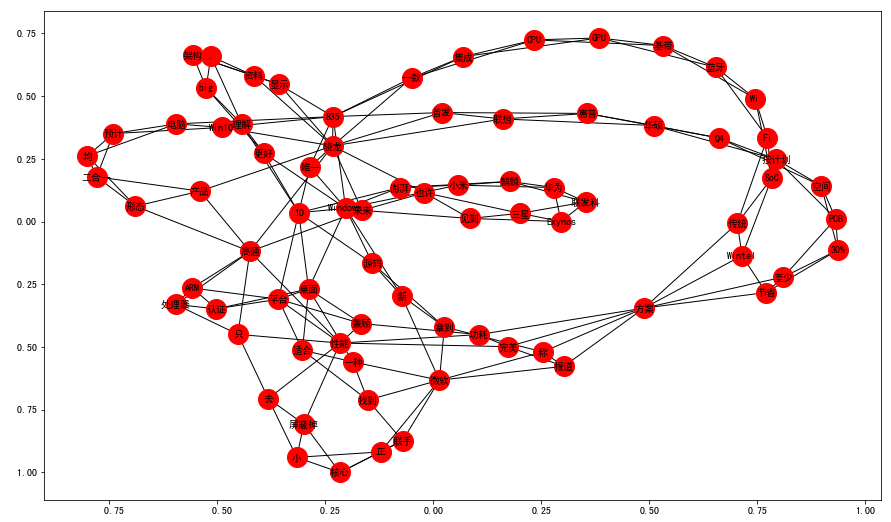

In [10]:
# 画无向图
import networkx as nx
import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = 'Arial Unicode MS'
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['font.family']='sans-serif'

G = nx.Graph()
for key in co_dict:
    G.add_edge(key[0],key[1])

plt.figure(figsize=(15, 9))
nx.draw_networkx(G,font_size=10,node_size=400)

plt.show()

In [38]:
# sentences = [' '.join(n) for n in news_content]
# len(sentences)

In [34]:
# sentence_path = './datasets/newtext.txt'
# def save_sentence(lines, sentence_path):
#     with open(sentence_path, 'w', encoding='utf-8') as f:
#         for line in lines:
#             f.write('%s\n' % line.strip())
#     print('save sentence:%s' % sentence_path)
# save_sentence(sentences,sentence_path)

save sentence:./datasets/newtext.txt


In [37]:
# from gensim.models import Word2Vec
# from gensim.models.word2vec import LineSentence
# # 调用gensim的包进行词向量的训练，使用skip-gram
# w2v = Word2Vec(sg=1, sentences=LineSentence(sentence_path),
#                    size=64, window=3, min_count=1, iter=5)

In [36]:
# from gensim.models.keyedvectors import KeyedVectors
# import pickle
# w2v_bin_path = './datasets/w2v.bin'
# w2v.wv.save_word2vec_format(w2v_bin_path, binary=True)
# print("save %s ok." % w2v_bin_path)

# # 加载模型
# model = KeyedVectors.load_word2vec_format(w2v_bin_path, binary=True)
# word_dict = {}
# out_path = './datasets/word2vec.txt'
# for word in model.vocab:
#     word_dict[word] = model[word]

# with open(out_path, 'wb') as f:
#     pickle.dump(word_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
#     print("save %s ok." % out_path)

#### 选做 1.  提取新闻人物里的对话。(使用以上提取小数据即可）

提示：    
1.寻找预料里具有表示说的意思。    
2.使用语法分析提取句子结构。    
3.检测谓语是否有表示说的意思。